# Agentic Adaptive RAG with LangGraph

In this notebook, we'll build the most sophisticated RAG system yet - one that adapts its strategy based on query complexity, evaluates result quality, and can even rewrite queries for better results.

## What is Adaptive RAG?

Adaptive RAG goes beyond simple routing by:
1. **Analyzing query complexity** to determine the best retrieval strategy
2. **Searching multiple collections** when queries span domains
3. **Evaluating result quality** and adapting if results are poor
4. **Rewriting queries** to improve retrieval when needed
5. **Self-correcting** through iterative refinement

## Learning Objectives

By the end of this notebook, you will:
- Understand query complexity analysis and strategy selection
- Build multi-collection search capabilities
- Implement response quality evaluation and grading
- Create query rewriting and expansion mechanisms
- Design self-correcting RAG workflows
- Compare adaptive RAG with simpler approaches

## Setup and Imports

We'll need additional imports for the adaptive functionality.

In [1]:
import os
from pathlib import Path
from typing import List, TypedDict, Literal, Optional, Tuple, Dict
import time
from collections import defaultdict

from dotenv import load_dotenv
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.retrievers import TavilySearchAPIRetriever
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field
from IPython.display import Image, display

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


In [2]:
# Parallel Logger for handling print statements in parallel execution
class ParallelLogger:
    """Buffered logger for organizing print statements during parallel execution."""
    
    def __init__(self, task_id: str):
        self.task_id = task_id
        self.logs = []
        self.start_time = time.time()
    
    def log(self, message: str, level: str = "INFO"):
        """Log a message with timestamp."""
        timestamp = time.time() - self.start_time
        self.logs.append({
            "timestamp": timestamp,
            "level": level,
            "message": message
        })
    
    def get_logs(self) -> List[dict]:
        """Get all logged messages."""
        return self.logs
    
    def print_logs(self, prefix: str = ""):
        """Print all logged messages in order."""
        for entry in self.logs:
            print(f"{prefix}[{entry['timestamp']:.2f}s] {entry['message']}")

class ParallelLogManager:
    """Manager for multiple parallel loggers."""
    
    def __init__(self):
        self.loggers = {}
        self.execution_order = []
    
    def get_logger(self, task_id: str) -> ParallelLogger:
        """Get or create a logger for a task."""
        if task_id not in self.loggers:
            self.loggers[task_id] = ParallelLogger(task_id)
            self.execution_order.append(task_id)
        return self.loggers[task_id]
    
    def print_all_logs(self, title: str = "Parallel Execution Results"):
        """Print all logs in organized format."""
        print(f"\n{'='*80}")
        print(f"{title}")
        print(f"{'='*80}")
        
        for task_id in self.execution_order:
            logger = self.loggers[task_id]
            print(f"\n--- Task: {task_id} ---")
            logger.print_logs("  ")
        
        print(f"{'='*80}")
    
    def clear(self):
        """Clear all loggers."""
        self.loggers.clear()
        self.execution_order.clear()

print("ParallelLogger system created!")

ParallelLogger system created!


## Environment Setup

Before we start building our adaptive RAG system, let's verify that all required API keys are available. We need both OpenAI for language models and embeddings, and Tavily for web search capabilities.

In [3]:
# Check if OpenAI API key is available
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY environment variable is required")

# Check if Tavily API key is available
tavily_api_key = os.getenv("TAVILY_API_KEY")
if not tavily_api_key:
    raise ValueError("TAVILY_API_KEY environment variable is required for web search functionality")

print("OpenAI API key found!")
print("Tavily API key found!")

OpenAI API key found!
Tavily API key found!


## Connect to ChromaDB Collections

We'll use the same domain-separated ChromaDB collections from the router RAG notebook. This separation allows us to route queries to the most appropriate knowledge domains: product catalog, FAQ, and troubleshooting guides.

In [4]:
# Initialize embeddings model
embeddings = OpenAIEmbeddings(
    model=os.getenv("OPENAI_EMBEDDING_MODEL", "text-embedding-3-small"),
    api_key=openai_api_key
)

# Path to the separate ChromaDB collections
chroma_db_path = Path("..") / "vector_store" / "chroma_db_separate"

# Connect to each collection
catalog_store = Chroma(
    collection_name="techmart_catalog",
    embedding_function=embeddings,
    persist_directory=str(chroma_db_path)
)

faq_store = Chroma(
    collection_name="techmart_faq",
    embedding_function=embeddings,
    persist_directory=str(chroma_db_path)
)

troubleshooting_store = Chroma(
    collection_name="techmart_troubleshooting",
    embedding_function=embeddings,
    persist_directory=str(chroma_db_path)
)

# Create a mapping for easy access
collections = {
    "catalog": catalog_store,
    "faq": faq_store,
    "troubleshooting": troubleshooting_store
}

print(f"Connected to ChromaDB collections at: {chroma_db_path}")
for name, store in collections.items():
    print(f"{name}: {store._collection.count()} documents")

Connected to ChromaDB collections at: ../vector_store/chroma_db_separate
catalog: 325 documents
faq: 50 documents
troubleshooting: 154 documents


## Initialize Language Models

For optimal performance, we use different specialized language models for different tasks:
- **Analysis LLM**: Most capable model for complex query analysis and decomposition
- **Generation LLM**: Balanced model for answer generation  
- **Evaluation LLM**: Fast model for document relevance evaluation

In [5]:
# Initialize separate language models for different tasks
# Analysis LLM - Most capable model for complex query analysis and decomposition
analysis_llm = ChatOpenAI(
    model="gpt-4o",
    api_key=openai_api_key,
)

# Generation LLM - Balanced model for answer generation
generation_llm = ChatOpenAI(
    model="gpt-4o-mini",
    api_key=openai_api_key,
)

# Evaluation LLM - Capable model for document relevance evaluation
evaluation_llm = ChatOpenAI(
    model="gpt-4o",
    api_key=openai_api_key,
)

print(f"Analysis language model initialized: {analysis_llm.model_name}")
print(f"Generation language model initialized: {generation_llm.model_name}")
print(f"Evaluation language model initialized: {evaluation_llm.model_name}")

Analysis language model initialized: gpt-4o
Generation language model initialized: gpt-4o-mini
Evaluation language model initialized: gpt-4o


## Subgraph State Definition

We need to define the state structure for processing individual queries through our subgraph. This state will track the journey of a single query from initial analysis through retrieval, evaluation, and generation.

In [6]:
# Subgraph state for individual query processing
class ProcessQueryGraphState(TypedDict):
    """State for processing a single query through the subgraph."""
    query: str
    rewritten_query: str
    reason_for_rewrite: str
    needs_rewrite: bool
    num_retries: int
    routing_decision: str
    retrieved_docs: List[Document]
    relevant_docs: List[Document]
    subquery_answer: str
    logger: ParallelLogger

print("Subgraph state definition created!")

Subgraph state definition created!


## Query Router

Now we'll create a query router chain that determines collections for each individual query.

In [7]:
class QueryRouting(BaseModel):
    """Routing decision for a single query."""
    collection_needed: Literal["catalog", "faq", "troubleshooting", "web_search"] = Field(
        description="Collections that should be searched"
    )
    reasoning: str = Field(
        description="Explanation of the routing decision"
    )

# Query routing prompt for individual queries
routing_prompt = ChatPromptTemplate.from_template(
    """You are a query router for TechMart's RAG system.
Determine which collections should be searched for this specific query.

Available collections:
- **catalog**: Product information, specifications, recommendations
- **faq**: Customer service, shipping, returns, policies
- **troubleshooting**: Technical support, problem diagnosis, solutions for TechMart products
- **web_search**: For troubleshooting questions about issues not covered in our internal troubleshooting database, or for getting the latest information about software, drivers, or technical problems that require current information from the internet

Search strategies:
- **single_collection**: Search one most relevant collection
- **multi_collection**: Search 2-3 relevant collections
- **comprehensive**: Search all collections for complex/vague queries

Collection selection rules:
- Use **web_search** for troubleshooting issues that are likely not covered in our limited internal database
- Use **web_search** for current software, driver, or OS compatibility issues
- Use internal collections (catalog, faq, troubleshooting) for TechMart-specific information

Examples:
1. "What gaming laptops do you have?" -> Collections: ["catalog"]
2. "What are your return policies?" -> Collections: ["faq"]
3. "My laptop won't turn on" -> Collections: ["troubleshooting"]
4. "Windows 11 blue screen error 0x0000007E" -> Collections: ["web_search"]
5. "Latest NVIDIA driver causing display issues" -> Collections: ["web_search"]
6. "I need a laptop" -> Collections: ["catalog"]

Query: {query}

Determine the routing:
"""
)

# Create routing chain
routing_chain = routing_prompt | analysis_llm.with_structured_output(QueryRouting)

print("Query router created!")

Query router created!


## Document Grading System

After retrieving documents, we need to evaluate their relevance to the query. This grading system helps us filter out irrelevant documents and determine if we need to retry with a rewritten query.

In [8]:
class DocumentGrade(BaseModel):
    """Grade for document relevance."""
    relevant: Literal["yes", "no"] = Field(
        description="Whether the document is relevant to the query"
    )
    reasoning: str = Field(
        description="Brief explanation of the relevance assessment"
    )

# Document grading prompt
grading_prompt = ChatPromptTemplate.from_template(
    """You are evaluating the relevance of a retrieved document to a user query.

Query: {query}

Document:
{document}

Instructions:
- Mark as "yes" if the document contains information that helps answer the query, even if:
  - The SKU number differs
  - The model variant or version name (e.g., “Wireless” vs. base model) is different but from the same product family
- Mark as "no" only if the product in the document is clearly a different, unrelated product line.
- Focus on the product family and core features described, not exact SKUs or small variant descriptors.
- Give brief reasoning for your assessment.
Evaluate the document relevance.
"""
)

# Create grading chain with evaluation LLM
grading_chain = grading_prompt | evaluation_llm.with_structured_output(DocumentGrade)

import asyncio
async def evaluate_documents(query: str, documents: List[Document], logger: ParallelLogger) -> List[Document]:
    """Evaluate document relevance in parallel and return relevant docs with quality score."""
    if not documents:
        logger.log("No documents to evaluate")
        return []
    
    logger.log(f"Evaluating {len(documents)} documents for query: {query}")
    
    # Evaluate all documents in parallel
    tasks = [
        grading_chain.ainvoke({"query": query, "document": doc.page_content}) 
        for doc in documents
    ]
    grades = await asyncio.gather(*tasks)
    
    # Process results
    relevant_docs = []
    
    for doc, grade in zip(documents, grades):
        if grade.relevant == "yes":
            relevant_docs.append(doc)
            logger.log(f"✓ Relevant doc: {grade.reasoning}")
        else:
            logger.log(f"✗ Irrelevant doc: {grade.reasoning}")
    
    logger.log(f"Document evaluation complete: {len(relevant_docs)}/{len(documents)} relevant")
    
    return relevant_docs

print("Document evaluation system created!")

Document evaluation system created!


## Query Rewriting and Expansion

When initial results are poor, we can rewrite the query to improve retrieval.

In [9]:
class QueryRewrite(BaseModel):
    """Rewritten query for better retrieval."""
    rewritten_query: str = Field(
        description="Improved version of the original query"
    )
    improvements: str = Field(
        description="Explanation of what was improved"
    )

# Query rewriting prompt - enhanced to handle context
rewrite_prompt = ChatPromptTemplate.from_template(
    """You are helping improve a query for better document retrieval.
The original query may need enhancement either for general improvement or by incorporating previous context.

Original query: {query}
Previous context: {previous_context}

Context: This is for a TechMart electronics store with products, customer service info, and troubleshooting guides.

Rewriting strategies:
- If previous_context is provided, incorporate specific findings (product names, models, details) into the query
- Add more specific terms and context from previous results
- Expand abbreviations and clarify ambiguous terms  
- Add relevant synonyms or alternative phrasings
- Make implicit requirements explicit

Examples with context:
- Original: "Check if has issues" + Context: "Found GlideMaster MX Wireless Mouse as best mouse" 
  → "Check if GlideMaster MX Wireless Mouse has known issues, problems, or user complaints"
- Original: "What about warranty" + Context: "User interested in ZenithBook 13 Evo laptop"
  → "What is the warranty coverage and terms for ZenithBook 13 Evo laptop"

Examples without context:
- "fast computer" → "high performance laptop with fast processor and SSD storage"
- "setup help" → "step by step guide for setting up and configuring new computer"
- "won't work" → "troubleshooting device not functioning properly or not turning on"

Provide an improved query:
"""
)

# Create rewriting chain with analysis LLM
rewrite_chain = rewrite_prompt | analysis_llm.with_structured_output(QueryRewrite)

print("Enhanced query rewriting system created using gpt-4.1!")

Enhanced query rewriting system created using gpt-4.1!


## Answer Generation for Subqueries

Each subquery processed through our subgraph needs to generate a focused answer based on the relevant documents found. This answer will later be combined with other subquery results to form the final response.

In [10]:
# Subquery answer generation

subquery_answer_generation_prompt = ChatPromptTemplate.from_template(
    """You are a helpful assistant for TechMart, an electronics retailer.
    Use the following relevant documents to answer the specific query.

    Query: {query}
    
    Context from relevant documents:
    {context}

    Instructions:
    - Provide a focused answer to this specific query
    - Be concise but informative
    - Include specific product details when available
    - If no relevant documents were found, acknowledge the limitation

    Answer:
    """
)

subquery_answer_generation_chain = subquery_answer_generation_prompt | generation_llm

print("Subquery answer generation chain created!")

Subquery answer generation chain created!


## Define Subgraph Nodes and Conditional Logic

Now we'll define the individual nodes that make up our subgraph workflow. Each node handles a specific step in processing a single query:

- **Query Rewriter**: Enhances queries with context (first node in the pipeline)
- **Router**: Determines which collection to search based on query content
- **Retrieval Nodes**: Search specific collections (catalog, FAQ, troubleshooting, web)
- **Evaluation**: Grades document relevance and determines if retry is needed
- **Answer Generation**: Creates focused responses from relevant documents

The conditional logic determines the flow between nodes, including retry mechanisms when initial retrieval fails to find relevant documents.

In [ ]:
# define the conditional edges that determine the next node to visit
def should_retry_with_rewrite(state: ProcessQueryGraphState) -> str:
    """Determine if query should be retried with rewriting or proceed to generation."""
    needs_rewrite = state.get("needs_rewrite", False)
    num_retries = state.get("num_retries", 0)
    logger = state["logger"]
    
    # Proceed to rewrite if flag is set and we haven't exceeded retry limit
    if needs_rewrite and num_retries < 2:
        logger.log(f"Will retry with query rewriting (attempt {num_retries}, needs_rewrite={needs_rewrite})")
        return "query_rewriter_node"
    else:
        # Either we don't need rewrite or already retried maximum times
        if needs_rewrite and num_retries >= 2:
            logger.log(f"Max retries reached ({num_retries}), proceeding to generation despite needing rewrite")
        else:
            logger.log(f"No rewrite needed or found relevant documents, proceeding to generation")
        return "generate_subquery_answer"

# define the nodes
def query_rewriter_node(state: ProcessQueryGraphState) -> ProcessQueryGraphState:
    """Rewrite query with context if needed, otherwise pass through."""
    query = state["query"]
    needs_rewrite = state.get("needs_rewrite", False)
    reason_for_rewrite = state.get("reason_for_rewrite", "")
    num_retries = state.get("num_retries", 0)
    logger = state["logger"]
    
    # Check if this is a retry due to no relevant docs
    if num_retries > 0:
        logger.log(f"Retrying query rewrite due to no relevant documents: {query}")
        reason_for_rewrite = "No relevant documents found, improving query for better retrieval"
        needs_rewrite = True
    
    if not needs_rewrite:
        # Skip rewriting, pass through original query
        logger.log(f"Skipping query rewrite for: {query}")
        return {
            "rewritten_query": query, 
            "needs_rewrite": False,
            "num_retries": num_retries
        }
    
    # Rewrite query using previous context
    logger.log(f"Rewriting query with context: {query}")
    logger.log(f"Previous context: {reason_for_rewrite}")
    
    rewrite_result = rewrite_chain.invoke({
        "query": query,
        "previous_context": reason_for_rewrite
    })
    
    logger.log(f"Original query: {query}")
    logger.log(f"Rewritten query: {rewrite_result.rewritten_query}")
    logger.log(f"Improvements: {rewrite_result.improvements}")
    
    return {
        "rewritten_query": rewrite_result.rewritten_query,
        "reason_for_rewrite": f"Enhanced: {rewrite_result.improvements}",
        "needs_rewrite": False,  # Always reset flag after rewriting
        "num_retries": num_retries  # Don't modify counter here
    }

def route_query(state: ProcessQueryGraphState) -> ProcessQueryGraphState:
    """Route individual query to appropriate collections."""
    # Use rewritten_query instead of query
    query = state["rewritten_query"]
    logger = state["logger"]
    
    # Route the query
    routing = routing_chain.invoke({"query": query})
    
    logger.log(f"Routing query: {query}")
    logger.log(f"Reasoning: {routing.reasoning}")
    
    return {
        "routing_decision": routing.collection_needed if routing.collection_needed else "catalog"
    }

def retrieve_from_catalog(state: ProcessQueryGraphState) -> ProcessQueryGraphState:
    """Retrieve documents from the product catalog."""
    query = state["rewritten_query"]  # Use rewritten_query
    logger = state["logger"]
    retrieved_docs = catalog_store.similarity_search(query, k=5)
    
    logger.log(f"Retrieved {len(retrieved_docs)} documents from catalog")
    for i, doc in enumerate(retrieved_docs, 1):
        source = doc.metadata.get('source', 'Unknown')
        content_preview = doc.page_content[:100]
        logger.log(f"  Doc {i} [{source}]: {content_preview}...")
    
    return {"retrieved_docs": retrieved_docs}

def retrieve_from_faq(state: ProcessQueryGraphState) -> ProcessQueryGraphState:
    """Retrieve documents from the FAQ collection."""
    query = state["rewritten_query"]  # Use rewritten_query
    logger = state["logger"]
    retrieved_docs = faq_store.similarity_search(query, k=5)
    
    logger.log(f"Retrieved {len(retrieved_docs)} documents from FAQ")
    for i, doc in enumerate(retrieved_docs, 1):
        source = doc.metadata.get('source', 'Unknown')
        content_preview = doc.page_content[:100]
        logger.log(f"  Doc {i} [{source}]: {content_preview}...")
    
    return {"retrieved_docs": retrieved_docs}

def retrieve_from_troubleshooting(state: ProcessQueryGraphState) -> ProcessQueryGraphState:
    """Retrieve documents from the troubleshooting collection."""
    query = state["rewritten_query"]  # Use rewritten_query
    logger = state["logger"]
    retrieved_docs = troubleshooting_store.similarity_search(query, k=5)
    
    logger.log(f"Retrieved {len(retrieved_docs)} documents from troubleshooting")
    for i, doc in enumerate(retrieved_docs, 1):
        source = doc.metadata.get('source', 'Unknown')
        content_preview = doc.page_content[:100]
        logger.log(f"  Doc {i} [{source}]: {content_preview}...")
    
    return {"retrieved_docs": retrieved_docs}

# Initialize Tavily retriever for web search
tavily_retriever = TavilySearchAPIRetriever(
    api_key=tavily_api_key,
    k=5,  # Number of search results to return
    include_generated_answer=False,
    include_raw_content=False
)

def retrieve_from_web_search(state: ProcessQueryGraphState) -> ProcessQueryGraphState:
    """Retrieve documents from web search using Tavily."""
    query = state["rewritten_query"]  # Use rewritten_query
    logger = state["logger"]
    
    # Use Tavily to search the web (updated for LangChain 0.3+)
    retrieved_docs = tavily_retriever.invoke(query)
    
    logger.log(f"Retrieved {len(retrieved_docs)} documents from web search")
    for i, doc in enumerate(retrieved_docs, 1):
        source = doc.metadata.get('source', 'Unknown')
        content_preview = doc.page_content[:100]
        logger.log(f"  Doc {i} [{source}]: {content_preview}...")
    
    return {"retrieved_docs": retrieved_docs}

async def evaluate_retrieved_documents(state: ProcessQueryGraphState) -> ProcessQueryGraphState:
    """Evaluate the quality of retrieved documents for a single query."""
    # Use rewritten_query for evaluation
    query = state["rewritten_query"]
    docs = state["retrieved_docs"]
    num_retries = state.get("num_retries", 0)
    logger = state["logger"]
    
    logger.log(f"Evaluating {len(docs)} documents for query: {query}")
    
    # Evaluate document relevance
    relevant_docs = await evaluate_documents(query, docs, logger)
    
    logger.log(f"Query Quality Assessment:")
    logger.log(f"Relevant docs: {len(relevant_docs)}/{len(docs)}")
    
    # Handle retry logic based on results
    if len(relevant_docs) == 0:
        # No relevant docs found - signal for retry and increment counter
        new_retries = num_retries + 1
        logger.log(f"No relevant docs found, setting needs_rewrite=True and incrementing retries: {num_retries} → {new_retries}")
        return {
            "relevant_docs": relevant_docs,
            "needs_rewrite": True,
            "num_retries": new_retries
        }
    else:
        # Found relevant docs - no retry needed
        logger.log(f"Found {len(relevant_docs)} relevant docs, no retry needed")
        return {
            "relevant_docs": relevant_docs,
            "needs_rewrite": False,
            "num_retries": num_retries  # Keep current value
        }

def generate_subquery_answer(state: ProcessQueryGraphState) -> ProcessQueryGraphState:
    """Generate answer for the subquery using relevant documents."""
    # Use rewritten_query for generation
    query = state["rewritten_query"]
    relevant_docs = state["relevant_docs"]
    logger = state["logger"]
    
    logger.log(f"Generating answer for subquery: {query}")
    
    # Prepare context from relevant documents
    if relevant_docs:
        context_parts = []
        for doc in relevant_docs:
            collection = doc.metadata.get('collection', 'unknown')
            source = doc.metadata.get('source', 'unknown')
            context_parts.append(f"[{collection.upper()}] {source}: {doc.page_content}")
        context_text = "\n\n".join(context_parts)
    else:
        context_text = "No relevant documents found for this subquery."
    
    # Generate response using the subquery generation chain
    response = subquery_answer_generation_chain.invoke({
        "query": query,
        "context": context_text
    })
    
    logger.log(f"Generated subquery answer: {response.content}")
    
    return {
        "subquery_answer": response.content
    }
    
def rewrite_query(state: ProcessQueryGraphState) -> ProcessQueryGraphState:
    """Rewrite query for better retrieval."""
    original_query = state["original_query"]
    retry_count = state["retry_count"]
    logger = state["logger"]
    
    logger.log(f"Rewriting query (attempt {retry_count + 1})...")
    
    # Rewrite the query
    rewrite = rewrite_chain.invoke({"query": original_query})
    
    logger.log(f"Original: {original_query}")
    logger.log(f"Rewritten: {rewrite.rewritten_query}")
    logger.log(f"Improvements: {rewrite.improvements}")
    
    return {
        "query": rewrite.rewritten_query,
        "rewritten_query": rewrite.rewritten_query,
        "needs_rewrite": False,
        "retry_count": retry_count + 1
    }

print("Subgraph nodes with fixed retry logic created!")

## Building the Subgraph

The subgraph handles the complete lifecycle of processing a single query, starting with query rewriting/enhancement, then routing → retrieval → evaluation → generation. It includes self-correction mechanisms to retry with rewritten queries when initial retrieval fails.

In [12]:
# Define routing function for conditional edges  
def route_to_retrieval_source(state: ProcessQueryGraphState) -> str:
    """Determine which retrieve node to call based on router decision."""
    routing_decision = state["routing_decision"]
    return f"retrieve_from_{routing_decision}"

# Build the subgraph
subgraph_builder = StateGraph(ProcessQueryGraphState)

# Add query rewriter node as new entry point
subgraph_builder.add_node("query_rewriter_node", query_rewriter_node)

# Add routing node
subgraph_builder.add_node("route_query", route_query)

# Add separate retrieval nodes
subgraph_builder.add_node("retrieve_from_catalog", retrieve_from_catalog)
subgraph_builder.add_node("retrieve_from_faq", retrieve_from_faq)
subgraph_builder.add_node("retrieve_from_troubleshooting", retrieve_from_troubleshooting)
subgraph_builder.add_node("retrieve_from_web_search", retrieve_from_web_search)

# Add evaluation node
subgraph_builder.add_node("evaluate_retrieved_documents", evaluate_retrieved_documents)

# Add generation node
subgraph_builder.add_node("generate_subquery_answer", generate_subquery_answer)

# Set entry point for subgraph to query rewriter
subgraph_builder.set_entry_point("query_rewriter_node")

# Add edge from query rewriter to router
subgraph_builder.add_edge("query_rewriter_node", "route_query")

# Add conditional edges from router to appropriate retrieve node
subgraph_builder.add_conditional_edges(
    "route_query",
    route_to_retrieval_source,
    {
        "retrieve_from_catalog": "retrieve_from_catalog",
        "retrieve_from_faq": "retrieve_from_faq", 
        "retrieve_from_troubleshooting": "retrieve_from_troubleshooting",
        "retrieve_from_web_search": "retrieve_from_web_search"
    }
)

# All retrieve nodes go to evaluation
subgraph_builder.add_edge("retrieve_from_catalog", "evaluate_retrieved_documents")
subgraph_builder.add_edge("retrieve_from_faq", "evaluate_retrieved_documents")
subgraph_builder.add_edge("retrieve_from_troubleshooting", "evaluate_retrieved_documents")
subgraph_builder.add_edge("retrieve_from_web_search", "evaluate_retrieved_documents")

# Add conditional edges from evaluation - either retry or proceed to generation
subgraph_builder.add_conditional_edges(
    "evaluate_retrieved_documents",
    should_retry_with_rewrite,
    {
        "query_rewriter_node": "query_rewriter_node",
        "generate_subquery_answer": "generate_subquery_answer"
    }
)

# Generation is the end
subgraph_builder.add_edge("generate_subquery_answer", END)

# Compile the subgraph
process_query_subgraph = subgraph_builder.compile()

print("Query processing subgraph with self-correction mechanism created and compiled!")

Query processing subgraph with self-correction mechanism created and compiled!


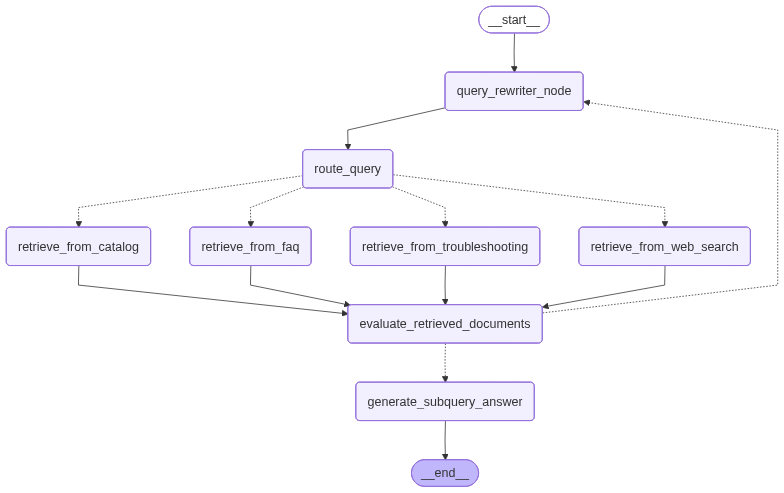

In [13]:
# visualize the subgraph
from IPython.display import Image, display

display(Image(process_query_subgraph.get_graph().draw_mermaid_png()))

## Query Analysis and Decomposition

The first step in our adaptive RAG system is analyzing the query to determine the optimal processing strategy. This analysis focuses specifically on **query decomposition** - deciding whether a complex query should be broken down into simpler sub-queries.

### Key Analysis Components:

1. **Decomposition Detection**: Identifies queries that contain multiple distinct questions or span unrelated domains
2. **Execution Planning**: Determines whether sub-queries should run in parallel (independent) or sequentially (dependent)
3. **Dependency Analysis**: Recognizes when later queries need results from earlier ones

### Examples of Decomposition:
- **Parallel**: "What laptops do you have AND what are your return policies?" → Two independent questions
- **Sequential**: "Find the best gaming mouse, THEN check if it has issues" → Second query depends on first result
- **No Decomposition**: "What are the specs of UltraBook Pro 14?" → Single cohesive question

This analysis enables our system to handle complex, multi-part queries more effectively than simple routing approaches.

In [14]:
class QueryAnalysis(BaseModel):
    """Analysis of query characteristics - focused on decomposition only."""
    needs_decomposition: bool = Field(
        description="Whether the query should be broken down into sub-queries"
    )
    sub_queries: List[str] = Field(
        description="List of sub-queries if decomposition is needed",
        default_factory=list
    )
    execution_plan: Literal["sequential", "parallel"] = Field(
        description="How sub-queries should be executed",
        default="parallel"
    )
    reasoning: str = Field(
        description="Explanation of the decomposition analysis"
    )

# Query analysis prompt - focused only on decomposition, not collection routing
query_analysis_prompt = ChatPromptTemplate.from_template(
    """You are a query decomposition analyzer for TechMart's adaptive RAG system.
Your job is to determine if a query needs decomposition.

Query decomposition rules:
- **Decompose if**: Query contains multiple distinct questions, has complex AND/OR logic, or spans multiple unrelated domains, or asks about multiple products
- **Don't decompose if**: Query is cohesive even if complex, or sub-parts heavily depend on each other

Execution plans:
- **sequential**: When later sub-queries depend on earlier results (e.g., "Find gaming laptops, then tell me about warranty for the best one")
- **parallel**: When sub-queries are independent (e.g., "What gaming laptops do you have and what are your shipping options?")

Examples:
1. "What gaming laptops do you have and what are your return policies?" 
   - Decompose: Yes, Sub-queries: ["What gaming laptops do you have?", "What are your return policies?"], Execution: parallel

2. "I need a laptop under $1000, then tell me how long shipping takes for my choice"
   - Decompose: Yes, Sub-queries: ["Show me laptops under $1000", "How long does shipping take?"], Execution: sequential

3. "What are the specs of the UltraBook Pro 14?"
   - Decompose: No

4. "Windows 11 blue screen error 0x0000007E - how do I fix this?"
   - Decompose: No

5. "My laptop won't turn on"
   - Decompose: No

6. "I need a laptop and want to know about Chrome crashes on macOS"
   - Decompose: Yes, Sub-queries: ["I need a laptop", "How to fix Chrome crashes on macOS"], Execution: parallel

Query: {query}

Provide your query analysis:
"""
)

# Create decomposition analysis chain with analysis LLM
query_analysis_chain = query_analysis_prompt | analysis_llm.with_structured_output(QueryAnalysis)

print("Query analysis system created using gpt-4.1!")

Query analysis system created using gpt-4.1!


## Test Query Analysis

Let's test our query analyzer with different types of queries.

In [15]:
# Test queries of varying complexity including decomposition examples
test_queries = [
    "What are the specs of the UltraBook Pro 14?",  # no decomposition
    "What gaming laptops do you have and what are your return policies?",  # parallel decomposition
    "battery life for zenithbook air 15 vs ultrabook 14 pro",  # parallel decomposition
    "I need a laptop and want to know about Chrome crashes on macOS",  # parallel decomposition
]

print("Testing Query Decomposition Analysis:")
print("=" * 90)

for query in test_queries:
    analysis = query_analysis_chain.invoke({"query": query})
    print(f"\nQuery: {query}")
    print(f"Needs Decomposition: {analysis.needs_decomposition}")
    if analysis.needs_decomposition:
        print(f"Sub-queries: {analysis.sub_queries}")
        print(f"Execution Plan: {analysis.execution_plan}")
    print(f"Reasoning: {analysis.reasoning}")
    print("-" * 80)

Testing Query Decomposition Analysis:

Query: What are the specs of the UltraBook Pro 14?
Needs Decomposition: False
Reasoning: The query "What are the specs of the UltraBook Pro 14?" is focused and cohesive, asking for specific details about a single product. There are no multiple distinct questions involved, nor complex logical operators that would require breaking it down into separate sub-tasks. Additionally, the parts of the query are inherently dependent on the product in question, and there is no overlapping of unrelated domains or requests for information on multiple products.
--------------------------------------------------------------------------------

Query: What gaming laptops do you have and what are your return policies?
Needs Decomposition: True
Sub-queries: ['What gaming laptops do you have?', 'What are your return policies?']
Execution Plan: parallel
Reasoning: The query contains two distinct questions: one asking about available gaming laptops and another about ret

## Define Main Graph State

The main graph coordinates the overall adaptive RAG process. It analyzes queries for decomposition, processes subqueries (either sequentially or in parallel), and combines results into a final answer.

In [16]:
class MainGraphState(TypedDict):
    """State for our 3-node Adaptive RAG workflow."""
    # Input
    query: str
    original_query: str
    
    # Query decomposition results
    needs_decomposition: bool
    sub_queries: List[str]
    execution_plan: str  # "sequential" or "parallel"
    
    # Results storage: query -> list of documents
    query_results: dict  # Dict[str, List[Document]]
    
    # Final results
    all_retrieved_docs: List[Document]
    
    # Output
    answer: str
    
print("Main graph state created!")

Main graph state created!


In [17]:
# Global log manager for parallel execution
log_manager = ParallelLogManager()

# define a helper function to process a single query using the subgraph
async def _process_single_query(query: str, needs_rewrite: bool = False, previous_context: str = "") -> Dict:
    """Process a single query through the subgraph."""
    # Create logger for this specific query
    logger = log_manager.get_logger(query)
    logger.log(f"Starting processing for query: {query}")
    
    # Initialize subgraph state with logger and all required fields
    subgraph_state = {
        "query": query,
        "rewritten_query": "",  # Will be set by query_rewriter_node
        "reason_for_rewrite": previous_context,
        "needs_rewrite": needs_rewrite,
        "num_retries": 0,  # Initialize retry counter
        "routing_decision": "",
        "retrieved_docs": [],
        "relevant_docs": [],
        "subquery_answer": "",
        "logger": logger
    }
    
    # Run the subgraph
    result = await process_query_subgraph.ainvoke(subgraph_state)
    
    logger.log(f"Completed processing for query: {query}")
    
    return {
        "query": query,
        "documents": result.get("relevant_docs", []),
        "subquery_answer": result.get("subquery_answer", "")
    }

## Main Graph Nodes

The main graph consists of three primary nodes that orchestrate the entire adaptive RAG workflow: query analysis, query processing, and final answer generation.

In [18]:
import asyncio

# 3-node main graph

def query_analysis(state: MainGraphState) -> MainGraphState:
    """Decompose query and determine execution plan."""
    query = state["query"]
    
    # Clear previous logs
    log_manager.clear()
    
    # Analyze the query for decomposition only
    analysis = query_analysis_chain.invoke({"query": query})
    
    print(f"Query Decomposition Analysis:")
    print(f"  Needs Decomposition: {analysis.needs_decomposition}")
    if analysis.needs_decomposition:
        print(f"  Sub-queries: {analysis.sub_queries}")
        print(f"  Execution Plan: {analysis.execution_plan}")
    print(f"  Reasoning: {analysis.reasoning}")
    
    return {
        "original_query": query,
        "needs_decomposition": analysis.needs_decomposition,
        "sub_queries": analysis.sub_queries if analysis.needs_decomposition else [query],
        "execution_plan": analysis.execution_plan,
        "query_results": {}
    }

async def process_queries(state: MainGraphState) -> MainGraphState:
    """Process queries using asyncio for sequential/parallel execution with organized logging."""
    sub_queries = state["sub_queries"]
    execution_plan = state["execution_plan"]
    needs_decomposition = state["needs_decomposition"]
    
    query_results = {}
    all_docs = []
    
    if not needs_decomposition:
        # Single query - no rewriting needed
        print(f"\nProcessing single query: {sub_queries[0]}")
        result = await _process_single_query(sub_queries[0], needs_rewrite=False)
        query_results[result["query"]] = result["documents"]
        all_docs.extend(result["documents"])
        
        # Print organized logs for single query
        log_manager.print_all_logs("Single Query Processing")
        
    elif execution_plan == "parallel":
        # Parallel execution - no rewriting needed for any query
        print(f"\nExecuting {len(sub_queries)} queries in parallel")
        
        # Create tasks for all queries (no context needed for parallel)
        tasks = [_process_single_query(query, needs_rewrite=False) for query in sub_queries]
        
        # Wait for all tasks to complete
        results = await asyncio.gather(*tasks)
        
        # Process results
        for result in results:
            query_results[result["query"]] = result["documents"]
            all_docs.extend(result["documents"])
        
        # Print organized logs for parallel execution
        log_manager.print_all_logs("Parallel Query Processing")
                
    else:  # sequential
        # Sequential execution with context accumulation
        print(f"\nExecuting {len(sub_queries)} queries sequentially")
        
        accumulated_context = ""
        for i, query in enumerate(sub_queries, 1):
            print(f"\n--- Sequential Step {i}/{len(sub_queries)} ---")
            
            # First query doesn't need rewriting, subsequent ones do
            needs_rewrite = i > 1
            
            result = await _process_single_query(
                query, 
                needs_rewrite=needs_rewrite, 
                previous_context=accumulated_context
            )
            
            query_results[result["query"]] = result["documents"]
            all_docs.extend(result["documents"])
            
            # Accumulate context for next query
            accumulated_context += f"Step {i} result: {result['subquery_answer']}\n"
            
            # Print logs for this step immediately
            if query in log_manager.loggers:
                print(f"\nStep {i} Processing Details:")
                log_manager.loggers[query].print_logs("  ")
    
    print(f"\n{'='*80}")
    print(f"Query Processing Summary:")
    print(f"  Total queries processed: {len(sub_queries)}")
    print(f"  Total documents retrieved: {len(all_docs)}")
    print(f"  Execution strategy: {execution_plan}")
    print(f"{'='*80}")
    
    return {
        "query_results": query_results,
        "all_retrieved_docs": all_docs,
    }

In [19]:
# Generation prompt for main graph
final_generate_prompt = ChatPromptTemplate.from_template(
    """You are a helpful assistant for TechMart, an electronics retailer.
Use the following context to answer the user's question accurately and helpfully.

Original Question: {original_question}
Query was decomposed: {was_decomposed}
{decomposition_info}

Total Relevant Documents: {num_docs}

Context:
{context}

Instructions:
- Provide a comprehensive answer based on the retrieved information
- If the query was decomposed, address each part of the original question
- If information spans multiple domains, organize your response clearly
- Be specific and helpful, mentioning product names and details when available
- If no relevant documents were found, provide a helpful response indicating limitations

Answer:
"""
)

def generate(state: MainGraphState) -> MainGraphState:
    """Generate final answer using combined results from all queries."""
    original_query = state["original_query"]
    needs_decomposition = state["needs_decomposition"]
    query_results = state["query_results"]
    all_docs = state["all_retrieved_docs"]
    
    print(f"Generating final answer with {len(all_docs)} total documents")
    
    # Prepare context from all documents
    if all_docs:
        context_parts = []
        for doc in all_docs:
            collection = doc.metadata.get('collection', 'unknown')
            source = doc.metadata.get('source', 'unknown')
            context_parts.append(f"[{collection.upper()}] {source}: {doc.page_content}")
        context_text = "\n\n".join(context_parts)
    else:
        context_text = "No relevant documents found."
    
    # Prepare decomposition info
    if needs_decomposition and query_results:
        decomposition_info = f"Sub-queries processed:\n"
        for query, docs in query_results.items():
            decomposition_info += f"  • {query} ({len(docs)} documents)\n"
        was_decomposed = "Yes"
    else:
        decomposition_info = ""
        was_decomposed = "No"
    
    # Generate response
    messages = final_generate_prompt.invoke({
        "context": context_text,
        "original_question": original_query,
        "was_decomposed": was_decomposed,
        "decomposition_info": decomposition_info,
        "num_docs": len(all_docs)
    })
    
    response = generation_llm.invoke(messages)
    
    print(f"Generated final answer")
    
    return {
        "answer": response.content
    }

print("Main graph nodes created!")

Main graph nodes created!


## Build the Main Graph

Now we'll create the main graph that uses subgraphs and the Send API for improved query processing.

In [20]:
# Create the 3-node main graph

# Build the main graph
graph_builder = StateGraph(MainGraphState)

# Add the 3 main nodes
graph_builder.add_node("query_analysis", query_analysis)
graph_builder.add_node("process_queries", process_queries)
graph_builder.add_node("generate", generate)

# Set entry point
graph_builder.set_entry_point("query_analysis")

# Linear flow: analysis -> process -> generate
graph_builder.add_edge("query_analysis", "process_queries")
graph_builder.add_edge("process_queries", "generate")
graph_builder.add_edge("generate", END)

# Compile the graph
main_graph = graph_builder.compile()

print("3-node Adaptive RAG graph compiled successfully!")

3-node Adaptive RAG graph compiled successfully!


## Visualize the Main Graph
Let's visualize our clean 3-node architecture.

Main Graph (3-node architecture):


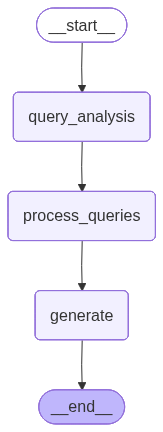

In [21]:
from IPython.display import Image, display

print("Main Graph (3-node architecture):")
display(Image(main_graph.get_graph().draw_mermaid_png()))

In [22]:
async def ask_adaptive_rag(query: str):
    """Ask a question to our Adaptive RAG system with organized logging."""
    print(f"\n{'='*100}")
    print(f"ADAPTIVE RAG QUERY: {query}")
    print(f"{'='*100}")
    
    # Run the adaptive RAG workflow
    result = await main_graph.ainvoke({"query": query})
    
    print(f"\n{'='*100}")
    print(f"FINAL ANSWER:")
    print(f"{'='*100}")
    print(f"{result['answer']}")
    print(f"{'='*100}")
    print("Query processing completed successfully!")
    print(f"{'='*100}")

## Testing the Adaptive RAG System

Let's test our adaptive RAG system with various query types to demonstrate its capabilities: parallel decomposition, sequential processing, web search integration, and product comparisons.

In [23]:
# Test with parallel decomposition query
await ask_adaptive_rag("What laptops do you have with Intel i7 processors and what are your return policies?")


ADAPTIVE RAG QUERY: What laptops do you have with Intel i7 processors and what are your return policies?
Query Decomposition Analysis:
  Needs Decomposition: True
  Sub-queries: ['What laptops do you have with Intel i7 processors?', 'What are your return policies?']
  Execution Plan: parallel
  Reasoning: The query contains two distinct questions: one about the availability of laptops with Intel i7 processors and another about return policies. These questions are unrelated in terms of logic and can be independently answered without reliance on each other's outcomes. Therefore, decomposition is warranted, and the execution can be executed in parallel since there's no dependency between the responses to the sub-queries. The decomposition will allow for more focused and potentially quicker responses from the system.

Executing 2 queries in parallel

Parallel Query Processing

--- Task: What laptops do you have with Intel i7 processors? ---
  [0.00s] Starting processing for query: What la

In [24]:
# Test with sequential decomposition query - now with context-aware enhancement
await ask_adaptive_rag("Find me the best mouse you have then check if it has any issues")


ADAPTIVE RAG QUERY: Find me the best mouse you have then check if it has any issues
Query Decomposition Analysis:
  Needs Decomposition: True
  Sub-queries: ['Find me the best mouse you have', 'Check if the best mouse has any issues']
  Execution Plan: sequential
  Reasoning: The query involves two distinct tasks with a dependency: identifying the best mouse first and then checking if that specifically chosen mouse has any issues. This step-wise progression necessitates decomposition as execution needs to occur sequentially. Each sub-query addresses different concerns and requires different evaluations; thus, decomposition aids in efficiently addressing each aspect of the request.

Executing 2 queries sequentially

--- Sequential Step 1/2 ---

Step 1 Processing Details:
  [0.00s] Starting processing for query: Find me the best mouse you have
  [0.00s] Skipping query rewrite for: Find me the best mouse you have
  [1.47s] Routing query: Find me the best mouse you have
  [1.47s] Reasonin

In [25]:
# Test with web search query
await ask_adaptive_rag("Windows 11 blue screen error 0x0000007E - how do I fix this?")


ADAPTIVE RAG QUERY: Windows 11 blue screen error 0x0000007E - how do I fix this?
Query Decomposition Analysis:
  Needs Decomposition: False
  Reasoning: The query 'Windows 11 blue screen error 0x0000007E - how do I fix this?' is cohesive and focused on a single issue: resolving a specific error on Windows 11. There are no distinct questions or multiple unrelated domains covered. The query does not contain complex AND/OR logic requiring breakdown, nor does it involve multiple products. Hence, it should not be decomposed.

Processing single query: Windows 11 blue screen error 0x0000007E - how do I fix this?


/var/folders/_1/tfp0k5355jxb501q_ckbc6m80000gn/T/ipykernel_32097/2592372435.py:136: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = tavily_retriever.get_relevant_documents(query)



Single Query Processing

--- Task: Windows 11 blue screen error 0x0000007E - how do I fix this? ---
  [0.00s] Starting processing for query: Windows 11 blue screen error 0x0000007E - how do I fix this?
  [0.00s] Skipping query rewrite for: Windows 11 blue screen error 0x0000007E - how do I fix this?
  [2.24s] Routing query: Windows 11 blue screen error 0x0000007E - how do I fix this?
  [2.24s] Reasoning: The query pertains to a specific error code occurring with Windows 11, which suggests a potential need for recent and external troubleshooting information. The internal troubleshooting collection may not cover this specific issue, particularly since both the error code and OS version are likely to have updates and changes that necessitate the most current information, best found via the web search collection.
  [3.06s] Retrieved 5 documents from web search
  [3.06s]   Doc 1 [https://learn.microsoft.com/en-us/answers/questions/3968710/frequent-blue-screen-with-error-code-0x0000007e-(w]

In [26]:
# Test a query that compares two products
await ask_adaptive_rag("battery life for zenithbook 11 vs ultrapook 14 pro")


ADAPTIVE RAG QUERY: battery life for zenithbook 11 vs ultrapook 14 pro
Query Decomposition Analysis:
  Needs Decomposition: True
  Sub-queries: ['What is the battery life for ZenithBook 11?', 'What is the battery life for UltraBook 14 Pro?']
  Execution Plan: parallel
  Reasoning: The query compares battery life for two distinct products, ZenithBook 11 and UltraBook 14 Pro. The two questions are independent of each other and do not require cross-dependence of results. Therefore, the query should be decomposed into two sub-queries that can be executed in parallel.

Executing 2 queries in parallel

Parallel Query Processing

--- Task: What is the battery life for ZenithBook 11? ---
  [0.00s] Starting processing for query: What is the battery life for ZenithBook 11?
  [0.00s] Skipping query rewrite for: What is the battery life for ZenithBook 11?
  [2.10s] Routing query: What is the battery life for ZenithBook 11?
  [2.10s] Reasoning: The query is specifically asking for product informat

## Interactive Testing

Try your own complex queries to see how the adaptive system handles them. The system will automatically analyze whether decomposition is needed and execute the appropriate strategy.

In [27]:
# Try your own query here!
your_question = ""
# await ask_adaptive_rag(your_question)

## Comparison: Adaptive RAG vs Router RAG

Let's compare how Adaptive RAG improves upon Router RAG:

### Adaptive RAG Advantages:

1. **Query Decomposition**: Automatically breaks complex multi-part questions into manageable sub-queries
2. **Context-Aware Sequential Processing**: Later sub-queries are enhanced with results from earlier ones
3. **Self-Correction**: Automatically rewrites queries when no relevant documents are found
4. **Quality Evaluation**: Documents are graded for relevance before answer generation
5. **Execution Optimization**: Parallel execution for independent sub-queries, sequential for dependent ones
6. **Multi-Collection Search**: Single queries can search across multiple domains simultaneously

### When Adaptive RAG Excels:

- **Multi-Part Questions**: "What laptops do you have and what are your return policies?"
- **Sequential Dependencies**: "Find the best mouse, then check if it has issues" → Enhanced second query with specific product
- **Comparison Queries**: "Battery life for ZenithBook vs UltraBook" → Parallel sub-queries for each product
- **Vague Queries**: "Fast thing" → Automatic rewriting to "high performance laptop with fast processor"
- **Mixed Domain Queries**: Product questions + technical troubleshooting in one query

### Remaining Challenges:

- **Increased Complexity**: More components and potential failure points
- **Higher Latency**: Multiple sub-query processing takes longer than single routing
- **API Cost**: More LLM calls for decomposition, evaluation, and potential rewrites
- **Decomposition Accuracy**: Incorrect query splitting can lead to suboptimal results

### Architecture Highlights:

- **Subgraph Design**: Each sub-query gets full routing → retrieval → evaluation → generation treatment
- **State Management**: Clean flag-based retry logic prevents infinite loops
- **Context Propagation**: Sequential queries build upon previous findings for targeted retrieval

This represents the most sophisticated RAG system, ideal for complex applications requiring high-quality answers over speed optimization.